In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [250]:
sheet_names = [
    'BSP', 
    'Veditum', 
    'Sand-nonmines'
]
sheet_id = "1Q1VfZWmh_BubeTz9Umjofx6Xz8bSb46xvrxBGNJupaE"
# sheet_name = "BSP"

dfs = []
for sheet_name in sheet_names:
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)
    dfs.append(df[['Id', 'latitude', 'longitude', 'Done labels']])



In [105]:
india_bio = gpd.read_file("/data/sand_mining/shapefiles/lyr_76_india_biogeographic.shp")
india_bio = india_bio.set_crs(4326, allow_override=True)

In [106]:
df_india = gpd.read_file("/data/sand_mining/shapefiles/India_Country_Boundary.shp")
df_india = df_india.to_crs('epsg:4326')

In [258]:
df_sample = pd.concat(dfs)
df_sample = df_sample[(df_sample['Done labels'] > 0) & 
          (~df_sample[['latitude', 'longitude']].isna().any(axis = 1))]
# df_sample = df_sample[~df_sample[['latitude', 'longitude']].isna().any(axis = 1)]

In [259]:
print(df_sample.shape)

(39, 4)


In [260]:
gdf_sample = gpd.GeoDataFrame(
    df_sample, geometry=gpd.points_from_xy(x=df_sample.longitude, y=df_sample.latitude)
)
gdf_sample = gdf_sample.set_crs(4326,allow_override=True )

In [261]:
df_join = gpd.sjoin(gdf_sample, india_bio, how = 'inner')
df_join = df_join.to_crs('epsg:4326')

In [262]:
df_join.biogeozone.value_counts()

biogeozone
Deccan Peninsula    18
Gangetic Plain      12
Semi-Arid            5
Coasts               4
Name: count, dtype: int64

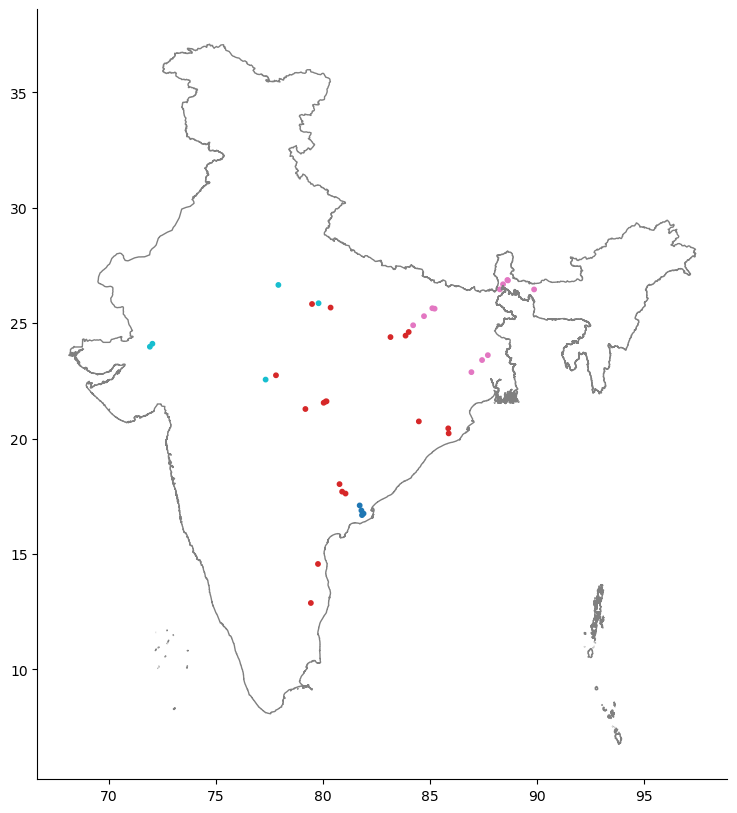

In [263]:
fig, ax = plt.subplots(figsize = (10, 10))
df_join.plot(column = 'biogeozone', facecolor = 'None', ax = ax, markersize = 10)
df_india.plot(facecolor = 'None', edgecolor = 'grey',  ax = ax)
sns.despine()
plt.show()

In [264]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [265]:
df_join1 = df_join.to_crs("epsg:32644")
df_join1['x'] = df_join1['geometry'].x
df_join1['y'] = df_join1['geometry'].y

X = df_join1[['x', 'y']].values


kmeans = AgglomerativeClustering(distance_threshold = 100000, n_clusters = None, linkage = 'single').fit(X)
df_join1[f'ag_means'] = kmeans.labels_

df_join1['cat'] = np.where(df_join1['latitude'] < 21.9, 1, 
         np.where(df_join1['longitude']< 82.5, 2, 3))


<Axes: xlabel='ag_means'>

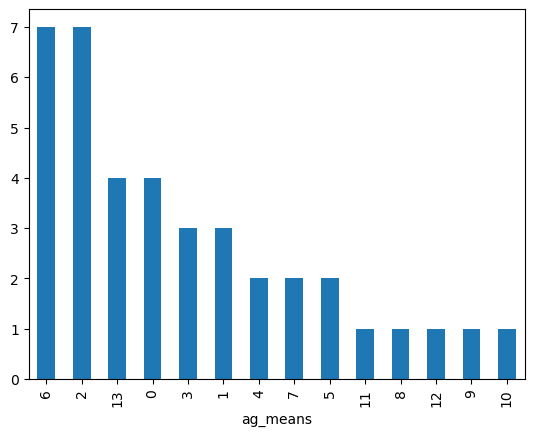

In [266]:
df_join1.ag_means.value_counts().plot(kind = 'bar')

In [330]:
df_join1.cat.value_counts()

cat
1    16
3    15
2     8
Name: count, dtype: int64

In [290]:
df_clusters = df_join1.ag_means.value_counts().reset_index()
df_clusters['cluster_group'] = df_clusters['count'].map({7: np.nan,  4:np.nan, 3:2, 2:3, 1:4})

In [329]:
# df_clusters[~df_clusters.ag_means.isin([6, 2, 13, 10])].groupby('cluster_group').sample(random_state = 42)

In [312]:
df_join1[df_join1.Id.isin(['n-4', 'b-22'])]

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
21,b-22,23.616222,87.69767,2.0,POINT (1184297.341 2627810.430),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.184297e+06,2.627810e+06,1,3
3,n-4,22.880000,86.93000,2.0,POINT (1109014.977 2542519.338),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.109015e+06,2.542519e+06,1,3


In [327]:
df_join1[(df_join1.cat == 1) &  
         (~df_join1.ag_means.isin([6, 2, 13, 0]))].drop_duplicates('ag_means').groupby('cat').sample(3, random_state = 154)

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
3,b-4,20.444176,85.847991,2.0,POINT (1006147.345 2268127.113),16,174691.0,156.0,1,0.0,...,2009-02-16,6C,Deccan Peninsula,Deccan Peninsula: Eastern Highlands,6,208121.91,1.006147e+06,2.268127e+06,5,1
27,b-27,12.876679,79.430004,2.0,POINT (329644.494 1424018.419),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.296445e+05,1.424018e+06,9,1
30,b-30,14.567470,79.762855,2.0,POINT (366724.988 1610849.097),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.667250e+05,1.610849e+06,10,1


In [325]:
df_join1[(df_join1.cat ==3) &  
         (~df_join1.ag_means.isin([6, 2, 13, 0]))].drop_duplicates('ag_means').groupby('cat').sample(2, random_state = 154)

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
21,b-22,23.616222,87.69767,2.0,POINT (1184297.341 2627810.430),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.184297e+06,2.627810e+06,1,3
10,v-17,26.463822,89.85844,2.0,POINT (1385159.188 2957705.041),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.385159e+06,2.957705e+06,8,3


In [321]:
df_join1[(df_join1.cat == 2) &  
         (~df_join1.ag_means.isin([6, 2, 13, 0]))].drop_duplicates('ag_means').groupby('cat').sample(1, random_state = 154)

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
0,b-1,26.659186,77.912883,2.0,POINT (192703.695 2952404.704),11,174686.0,156.0,1,0.0,...,2009-02-16,4B,Semi-Arid,Semi-Arid: Gujarat Rajputana,4,421857.93,192703.694949,2.952405e+06,11,2


In [332]:
df_join1[df_join1['ag_means'].isin([5, 9, 8, 1, 11, 10])]

,Id,latitude,longitude,Done labels,geometry,index_right,__mlocate_,__mlocate0,__mlocate1,__mlocate2,...,__mlocate8,prov_code,biogeozone,biogeoprov,zone_code,area_sqkm,x,y,ag_means,cat
0,b-1,26.659186,77.912883,2.0,POINT (192703.695 2952404.704),11,174686.0,156.0,1,0.0,...,2009-02-16,4B,Semi-Arid,Semi-Arid: Gujarat Rajputana,4,421857.93,1.927037e+05,2.952405e+06,11,2
3,b-4,20.444176,85.847991,2.0,POINT (1006147.345 2268127.113),16,174691.0,156.0,1,0.0,...,2009-02-16,6C,Deccan Peninsula,Deccan Peninsula: Eastern Highlands,6,208121.91,1.006147e+06,2.268127e+06,5,1
2,v-6,20.226477,85.867090,2.0,POINT (1008859.853 2244028.474),16,174691.0,156.0,1,0.0,...,2009-02-16,6C,Deccan Peninsula,Deccan Peninsula: Eastern Highlands,6,208121.91,1.008860e+06,2.244028e+06,5,1
21,b-22,23.616222,87.697670,2.0,POINT (1184297.341 2627810.430),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.184297e+06,2.627810e+06,1,3
24,b-24.1,23.404413,87.427526,2.0,POINT (1157674.389 2602984.407),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.157674e+06,2.602984e+06,1,3
10,v-17,26.463822,89.858440,2.0,POINT (1385159.188 2957705.041),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.385159e+06,2.957705e+06,8,3
3,n-4,22.880000,86.930000,2.0,POINT (1109014.977 2542519.338),20,174695.0,156.0,1,0.0,...,2009-02-16,7B,Gangetic Plain,Gangetic Plain: Lower,7,149055.61,1.109015e+06,2.542519e+06,1,3
27,b-27,12.876679,79.430004,2.0,POINT (329644.494 1424018.419),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.296445e+05,1.424018e+06,9,1
30,b-30,14.567470,79.762855,2.0,POINT (366724.988 1610849.097),18,174693.0,156.0,1,0.0,...,2009-02-16,6E,Deccan Peninsula,Deccan Peninsula: Deccan South,6,342625.73,3.667250e+05,1.610849e+06,10,1


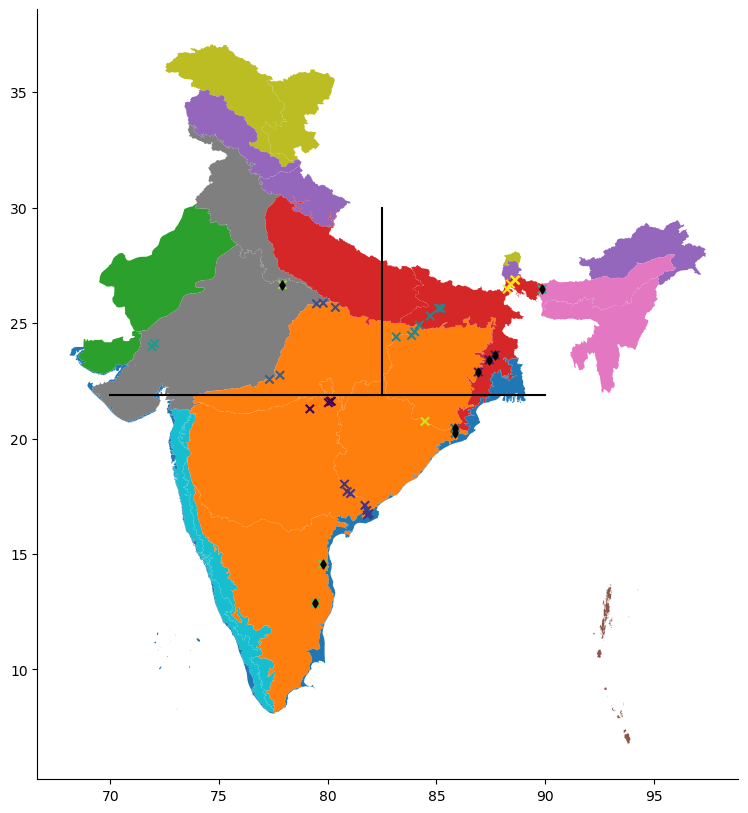

In [331]:
fig, ax = plt.subplots(figsize = (10, 10))
india_bio.plot(column = 'biogeozone', ax = ax)
df_join1.to_crs('epsg:4326').plot(column = 'ag_means', ax = ax, marker = 'x')
plt.plot([82.5, 82.5], [21.9, 30], 'k-')
plt.plot([70, 90], [21.9, 21.9], 'k-')
df_join1[df_join1['ag_means'].isin([5, 9, 8, 1, 11, 10])].to_crs('epsg:4326').plot(marker = 'd', color = 'black', markersize = 20,
                                                                              ax = ax)
sns.despine()
plt.show()

<Axes: xlabel='ag_means'>

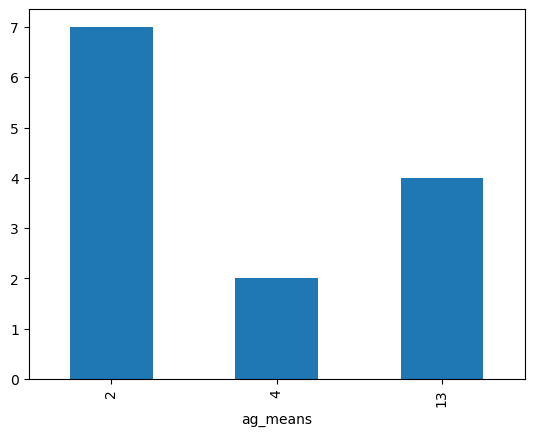

In [270]:
df_join1[df_join1['ag_means'].isin([2, 4, 13])].groupby('ag_means').size().plot(kind = 'bar')

<Axes: xlabel='cat,ag_means'>

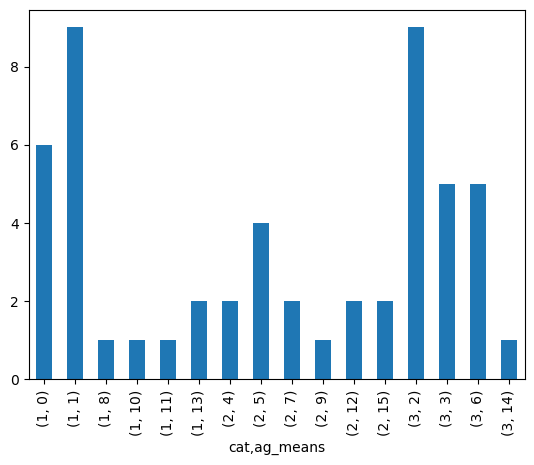

In [211]:
df_join1.groupby(['cat', 'ag_means']).size().plot(kind = 'bar')

In [136]:
# X = df_join[['latitude', 'longitude']].values

# kmeans_vals = []
# for i in range(1, 20):
#     kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(X)
#     kmeans_vals.append(kmeans)

C:\Users\suraj\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suraj\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suraj\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suraj\anaconda3\envs\geo_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

In [137]:
df_join1 = df_join.copy()

In [138]:
i = 1
for d in kmeans_vals:
    df_join1[f'means_{i}'] = d.labels_
    i+=1

<Axes: xlabel='means_6'>

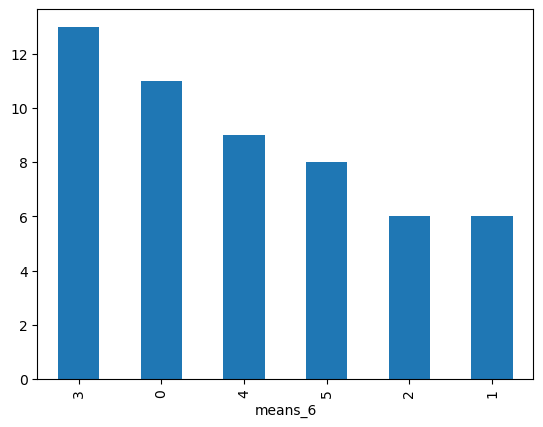

In [150]:
df_join1['means_6'].value_counts().plot(kind = 'bar')

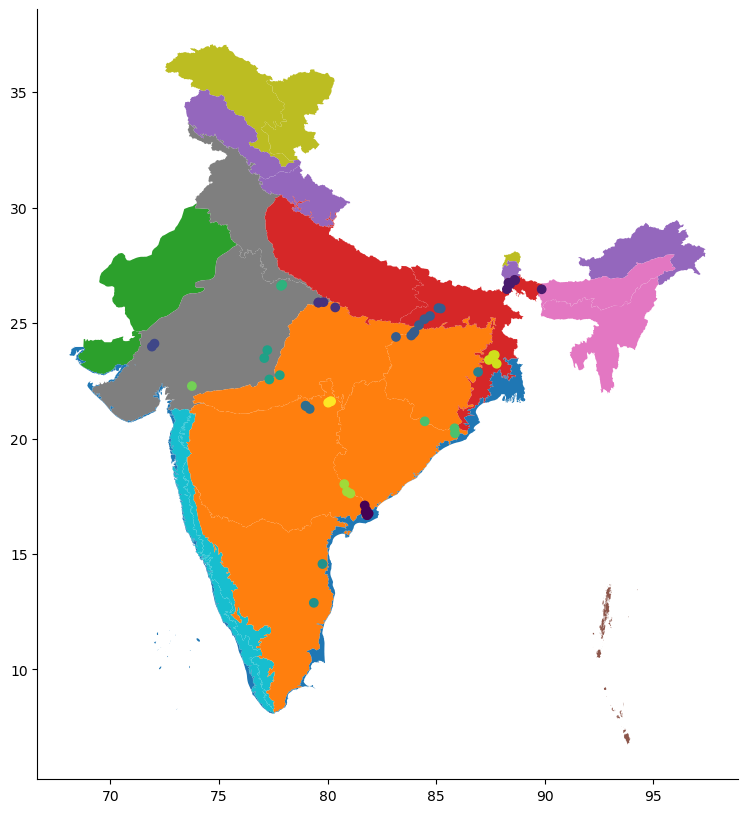

In [154]:
fig, ax = plt.subplots(figsize = (10, 10))
india_bio.plot(column = 'biogeozone', ax = ax)
df_join1.plot(column = 'means_15', ax = ax)
sns.despine()
plt.show()

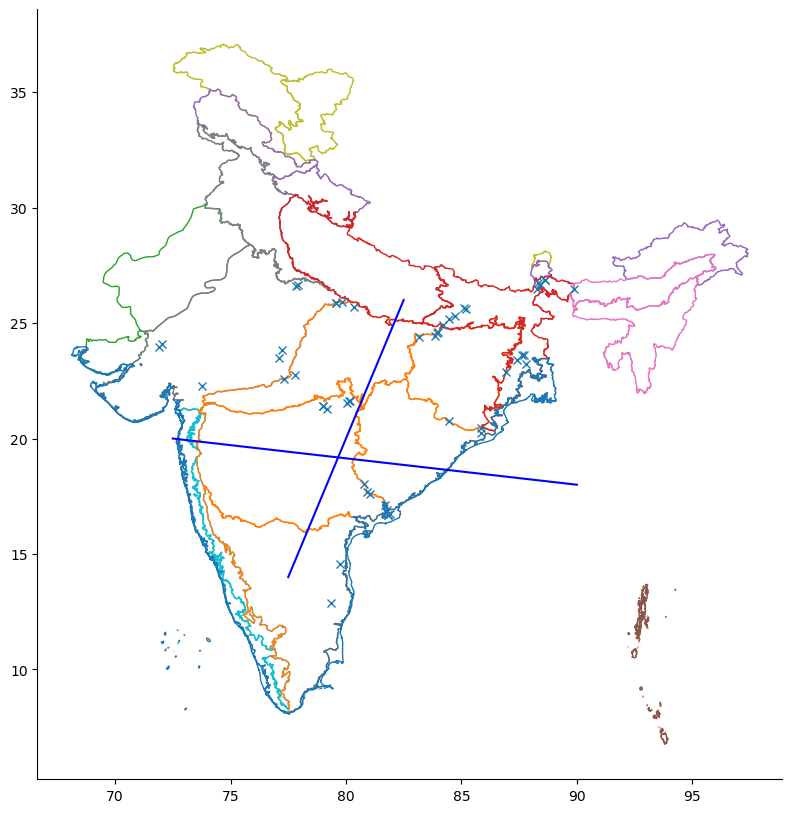

In [21]:
fig, ax = plt.subplots(figsize = (10, 10))
india_bio.plot(column = 'biogeozone', facecolor = 'None', ax = ax)
ax.plot(df_sample.longitude, df_sample.latitude, 'x')
ax.plot([72.5, 90], [20, 18], 'b-')
ax.plot([77.5, 82.5], [14, 26], 'b-')
sns.despine()
plt.show()